In [1]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms

In [2]:
import torch
from torchvision import datasets, transforms as T
import torchvision
import time
import copy
import os

In [18]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True,num_classes=1000)
resnext50_32x4d.fc = torch.nn.Sequential(torch.nn.Linear(in_features=2048,
                                               out_features=2))


In [4]:
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
from torch.utils.data import Dataset
use_cuda = False

trans = torchvision.transforms.Compose(
[
    torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

data_dir = './New Masks Dataset/Face Mask Dataset'
MODEL_STORE_PATH = './'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'faces': transforms.Compose([
#         transforms.RandomResizedCrop(64),
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}
def get_dataset(data_dir, data_transforms ):
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes
train_dataloader, test_dataloader , classes, dataset_sizes=get_dataset(data_dir,data_transforms)
print('Classes: ',  classes)

Classes:  ['WithMask', 'WithoutMask']


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnext50_32x4d.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = resnext50_32x4d.fc.in_features
resnext50_32x4d.fc = nn.Linear(num_ftrs, 128)
net = resnext50_32x4d
net = net.cuda() if device else net

In [11]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/5], Step [0/2500], Loss: 4.8830
Epoch [1/5], Step [20/2500], Loss: 4.7898
Epoch [1/5], Step [40/2500], Loss: 4.7387
Epoch [1/5], Step [60/2500], Loss: 4.4770
Epoch [1/5], Step [80/2500], Loss: 4.8018
Epoch [1/5], Step [100/2500], Loss: 4.5537
Epoch [1/5], Step [120/2500], Loss: 4.6927
Epoch [1/5], Step [140/2500], Loss: 4.9196
Epoch [1/5], Step [160/2500], Loss: 3.8392
Epoch [1/5], Step [180/2500], Loss: 2.7799
Epoch [1/5], Step [200/2500], Loss: 2.3399
Epoch [1/5], Step [220/2500], Loss: 1.7050
Epoch [1/5], Step [240/2500], Loss: 1.1089
Epoch [1/5], Step [260/2500], Loss: 1.1764
Epoch [1/5], Step [280/2500], Loss: 5.3158
Epoch [1/5], Step [300/2500], Loss: 0.7774
Epoch [1/5], Step [320/2500], Loss: 2.4155
Epoch [1/5], Step [340/2500], Loss: 2.7949
Epoch [1/5], Step [360/2500], Loss: 1.1712
Epoch [1/5], Step [380/2500], Loss: 1.2546
Epoch [1/5], Step [400/2500], Loss: 5.3637
Epoch [1/5], Step [420/2500], Loss: 0.5587
Epoch [1/5], Step [440/2500], Loss: 1.4600
Epoch [1

Epoch [2/5], Step [1220/2500], Loss: 0.3568
Epoch [2/5], Step [1240/2500], Loss: 0.1864
Epoch [2/5], Step [1260/2500], Loss: 0.2088
Epoch [2/5], Step [1280/2500], Loss: 0.1444
Epoch [2/5], Step [1300/2500], Loss: 0.3671
Epoch [2/5], Step [1320/2500], Loss: 0.2488
Epoch [2/5], Step [1340/2500], Loss: 0.7299
Epoch [2/5], Step [1360/2500], Loss: 0.2007
Epoch [2/5], Step [1380/2500], Loss: 0.2747
Epoch [2/5], Step [1400/2500], Loss: 0.2512
Epoch [2/5], Step [1420/2500], Loss: 0.3065
Epoch [2/5], Step [1440/2500], Loss: 0.1682
Epoch [2/5], Step [1460/2500], Loss: 0.2520
Epoch [2/5], Step [1480/2500], Loss: 0.2305
Epoch [2/5], Step [1500/2500], Loss: 0.2219
Epoch [2/5], Step [1520/2500], Loss: 0.3254
Epoch [2/5], Step [1540/2500], Loss: 0.2334
Epoch [2/5], Step [1560/2500], Loss: 0.3438
Epoch [2/5], Step [1580/2500], Loss: 0.0845
Epoch [2/5], Step [1600/2500], Loss: 0.2823
Epoch [2/5], Step [1620/2500], Loss: 0.0930
Epoch [2/5], Step [1640/2500], Loss: 0.2608
Epoch [2/5], Step [1660/2500], L

Epoch [3/5], Step [2420/2500], Loss: 0.5604
Epoch [3/5], Step [2440/2500], Loss: 3.4011
Epoch [3/5], Step [2460/2500], Loss: 0.1225
Epoch [3/5], Step [2480/2500], Loss: 0.1762

train-loss: 1.0362, train-acc: 91.9400
validation loss: 0.4272, validation acc: 98.2863

Improvement-Detected, save-model
Epoch 4

Epoch [4/5], Step [0/2500], Loss: 0.1248
Epoch [4/5], Step [20/2500], Loss: 3.5865
Epoch [4/5], Step [40/2500], Loss: 0.1638
Epoch [4/5], Step [60/2500], Loss: 0.1567
Epoch [4/5], Step [80/2500], Loss: 0.0632
Epoch [4/5], Step [100/2500], Loss: 0.1216
Epoch [4/5], Step [120/2500], Loss: 0.1314
Epoch [4/5], Step [140/2500], Loss: 0.0542
Epoch [4/5], Step [160/2500], Loss: 0.1343
Epoch [4/5], Step [180/2500], Loss: 0.1291
Epoch [4/5], Step [200/2500], Loss: 0.0542
Epoch [4/5], Step [220/2500], Loss: 0.1115
Epoch [4/5], Step [240/2500], Loss: 0.1518
Epoch [4/5], Step [260/2500], Loss: 0.1212
Epoch [4/5], Step [280/2500], Loss: 0.1218
Epoch [4/5], Step [300/2500], Loss: 0.1943
Epoch [4/5

Epoch [5/5], Step [1080/2500], Loss: 0.0408
Epoch [5/5], Step [1100/2500], Loss: 0.0577
Epoch [5/5], Step [1120/2500], Loss: 0.0857
Epoch [5/5], Step [1140/2500], Loss: 0.0851
Epoch [5/5], Step [1160/2500], Loss: 0.1168
Epoch [5/5], Step [1180/2500], Loss: 0.1289
Epoch [5/5], Step [1200/2500], Loss: 0.0483
Epoch [5/5], Step [1220/2500], Loss: 0.0913
Epoch [5/5], Step [1240/2500], Loss: 0.1425
Epoch [5/5], Step [1260/2500], Loss: 0.2057
Epoch [5/5], Step [1280/2500], Loss: 0.2723
Epoch [5/5], Step [1300/2500], Loss: 0.0996
Epoch [5/5], Step [1320/2500], Loss: 0.3259
Epoch [5/5], Step [1340/2500], Loss: 0.0937
Epoch [5/5], Step [1360/2500], Loss: 0.0636
Epoch [5/5], Step [1380/2500], Loss: 0.1218
Epoch [5/5], Step [1400/2500], Loss: 0.0932
Epoch [5/5], Step [1420/2500], Loss: 0.0609
Epoch [5/5], Step [1440/2500], Loss: 0.0962
Epoch [5/5], Step [1460/2500], Loss: 0.0924
Epoch [5/5], Step [1480/2500], Loss: 0.1652
Epoch [5/5], Step [1500/2500], Loss: 0.0808
Epoch [5/5], Step [1520/2500], L

In [12]:
import matplotlib.pyplot as plt

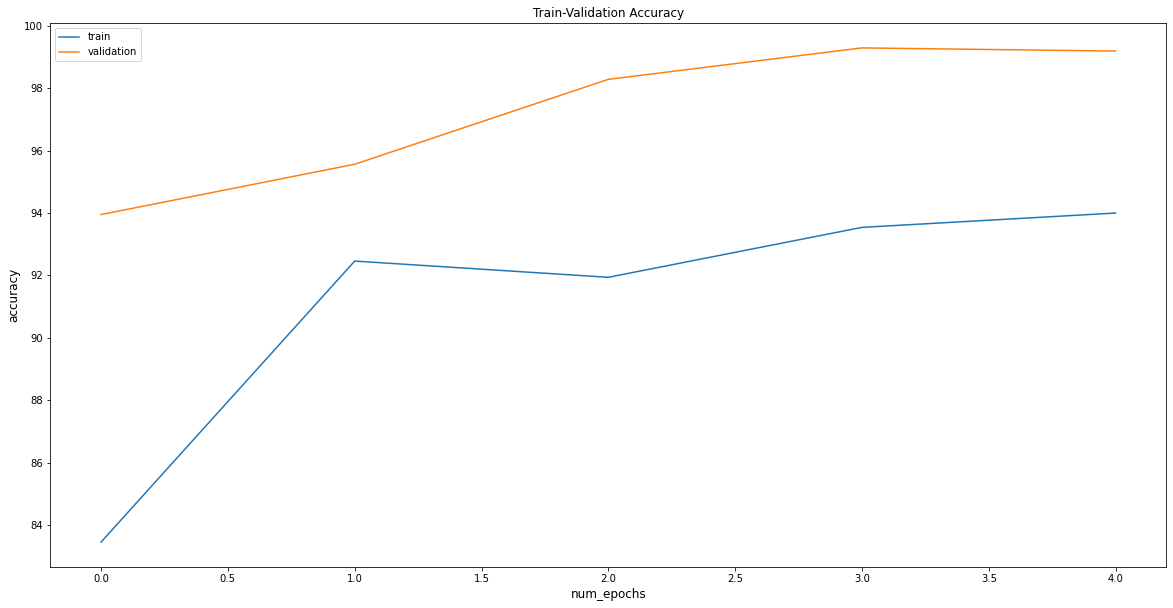

In [13]:
ig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [14]:
from matplotlib.pyplot import * 
from PIL import Image

In [25]:
from torch.utils.data import Dataset
use_cuda = True

trans = torchvision.transforms.Compose(
[
    torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [20]:
net.load_state_dict(torch.load('resnet.pt'))
test_dataset = torchvision.datasets.ImageFolder(root='./New Masks Dataset/Face Mask Dataset/Validation', transform=trans)

In [21]:
data_dir_valid = './New Masks Dataset/Face Mask Dataset/Validation'
MODEL_STORE_PATH = './'
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}

train_dataloader1, test_dataloader1 , classes1, dataset_sizes1=get_dataset(data_dir,data_transforms)
print('Classes: ',  classes1)

Classes:  ['WithMask', 'WithoutMask']


In [27]:
def model_metric(net):
    alls = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    j=0
    for i, data in enumerate(train_dataloader1):
        j+=1
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        if ((labels[3] == preds[3]) and (preds[3] == 1)) : tp+=1
        if ((labels[3] != preds[3]) and (preds[3] == 1)): fp+=1
        if ((labels[3] != preds[3]) and (preds[3] == 0)): fn+=1
        if ((labels[3] == preds[3]) and (preds[3] == 0)): tn+=1
    recall = (tp)/(tp+fn)
    precision = (tp)/(tp+fp)
    f1 = 2*((precision*recall)/(precision+recall))
    print("False Negative = ",fn)
    print("Recall =",recall )
    print("Precision =",precision )
    print("f1 =", f1 )
    print(j)
    
    
def visualize_model(net, num_images=12):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader1):

        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j][0,:,:])
            #imshow(torchvision.utils.make_grid(torch.reshape(inputs[j], ([64, 64, 3]))))
            #imshow(torchvision.utils.make_grid(inputs[j]))
            if images_so_far == num_images:
                return 

#plt.ion()
#visualize_model(net)
#plt.ioff()
model_metric(net)

False Negative =  30
Recall = 0.9751861042183623
Precision = 0.9671862182116489
f1 = 0.971169686985173
2500


In [16]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True,num_classes=1000)
resnext50_32x4d.fc = torch.nn.Sequential(torch.nn.Linear(in_features=2048,
                                               out_features=2))
resnext50_32x4d.load_state_dict(torch.load('resnet.pt'))
net = resnext50_32x4d

In [17]:
data_transforms =  transforms.Compose([
            transforms.Resize(64, interpolation=2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        ])
    

In [19]:
from PIL import Image
frame =Image.open("C:/University/Магистратура 4 семестр/CraftDS/NM/10.jpg")  
img = data_transforms(frame)
torch.Tensor(img).unsqueeze(3).shape

start_time = time.time()
output = net(torch.Tensor(img).unsqueeze(0))
time1 = (time.time() - start_time)
time1

0.29763293266296387